Ce code permet l'obtention de diagramme de prédominence, ainsi que des simulations de courbe de titrage pH-métrique avec comme solution titrante une solution de soude de concentration variable. 

Il est également possible de prévisualiser le titrage des espèces acido-basiques prisent seuls, mais également en mélangeant les deux dans des proportions adaptables. Ce code a été insipiré par l'article :  Kalka, H. Polyprotic Acids and Beyond—An Algebraic Approach.
        Chemistry 2021, 3, 454-508.
        [https://www.mdpi.com/2624-8549/3/2/34]

# Elèment de modélisation 
## Notations utilisées
Tout d'abord, il est primordial de formaliser le cadre de l'étude. Considérons donc une transformation d'un acide simple se dissolvant dans l'eau: 
$$ \mathrm{HA} = \mathrm{H^+} + \mathrm{A^-} $$
Un acide dit N-protique $\mathrm{H_NA}$ peut se dissoudre en N espèces : 

$$ \mathrm{H_{N-1}A^{-1}},\dots,\mathrm{HA^{-(N-1)}}, \mathrm{A^{-N}} $$

A noter que ces espèces sont des anions, ce qui est à prendre en compte dans l'équation d'électroneutralité de la solution. Pour simplifier les notations, on emploiera la notation suivante: 

$$ [j] \equiv [\mathrm{H_{N-j}A^{-j}}] \quad \text{for} \quad j=0,1,\dots,N$$

Le nombre entier $j$ permets aussi de labéliser la charge électrique de l'espèce considérer. On notera donc par l'index $0$ l'espèce non dissociée $\mathrm{H_NA}$.

la conservation de la matière nous permet d'établir la relation sur la concentration total d'acide présent $C_T$ : 

$$ C_T \equiv \sum_{j=0}^N \;[j] $$



## Paramètres fondamentaux du titrages

Comme nous l'expliquerons plus en détail dans la suite, le pH joue un rôle fondamental dans le titrage, c'est en fait le seul degré de liberté que nous avons, on notera donc $x$, l'activité des ion $\mathrm{H^+}$ en solution, il vient donc que : 
$$ x = [\mathrm{H^+}] \Leftrightarrow x = C^\circ \;10^{-pH}  $$

Il est également possible d'introduire la quantité $w$ qui rend compte de la différence de concentration entre $\mathrm{HO^-}$ et $\mathrm{H^+}$.
$$ w(x) \equiv [\mathrm{HO^-}] - [\mathrm{H^+}] = \frac{K_e}{x} - x $$

Les dissociations successivent sont déterminées par les valeurs des $\mathrm{pK_A}$ que l'on note par simplification pour la j-ème dissociation $K_j$. 

On peut donc écrire :
$$ \mathrm{H_N A} = \mathrm{H_{N-1} A^-} + \mathrm{H^+} \quad k_1 = K_1$$
$$ \mathrm{H_N A} = \mathrm{H_{N-j} A^{-j}} + j \mathrm{H^+} \quad k_j = K_1\dots K_j$$

En prenant en compte toutes les espèces actives du système, on a : $\mathrm{H^+}, \mathrm{HO^-}, \underbrace{\mathrm{H_N A},  \mathrm{H_{N-1} A^-}, \dots , \mathrm{H_{N-j} A^{-j}}, \dots \mathrm{A^{-N}}}_{N+1 \, \text{especes acides}}, \mathrm{B^+}$ 
On a donc un ensemble de $N+4$ espèces actives, le nombre d'équations mathématiques à disposition est de $N+3$ :

$$ K_e = \frac{[\mathrm{H^+}] \; [\mathrm{HO^-}]}{(C^\circ)^2} \quad \text{autoprotolyse de l'eau} $$
$$ K_1 = \frac{[\mathrm{H^+}] \; [1]}{C^\circ \; [\mathrm{H_N A}]} \quad \text{première dissociation}$$
$$ \vdots $$
$$ K_N = \frac{[\mathrm{H^+}] \; [N]}{C^\circ \; [N-1]} \quad \text{n-ième dissociation} $$
$$ C_T = \sum_{j=0}^N \;[j] \quad \text{conservation de la matière}$$
$$ C_B =  \sum_{j=0}^N \; j\times [j] + [\mathrm{HO^-}] - [\mathrm{H^+}] \quad \text{electro-neutralité}$$

Ainsi, nous avons un seul degré de liberté, la connaissance du pH nous permet alors de déterminer toutes les grandeurs du systèmes. 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

# Configuration des paramètres globaux
plt.style.use('seaborn-v0_8-whitegrid')
Ke = 1e-14
pH_range = np.linspace(0, 14, 10000)
Cb = 0.20  # Concentration de la base

# Configuration des espèces acido-basiques
species_config = {
    'Acide citrique': {
        'pKas': [3.13, 4.76, 6.40],
        'Ca': 0.10,
        'Va': 10.0,
        'colors': ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'],
        'cmap': LinearSegmentedColormap.from_list('citrique', ['#2E86AB', '#C73E1D'])
    },
    'Acide phosphorique': {
        'pKas': [2.15, 7.20, 12.35],
        'Ca': 0.10,
        'Va': 10.0,
        'colors': ['#3A7D44', '#FFD166', '#06AED5', '#6A4C93'],
        'cmap': LinearSegmentedColormap.from_list('phosphorique', ['#3A7D44', '#6A4C93'])
    }
}


def calculate_species_distribution(pH, pKas):
    """Calcule la distribution des espèces"""
    x = 10**-pH
    Kas = [10**-pKa for pKa in pKas]
    
    denominator = np.ones_like(x)
    for i in range(1, len(Kas)+1):
        denominator += np.prod(Kas[:i]) / (x**i)
    
    alphas = [1 / denominator]
    for i in range(1, len(Kas)+1):
        alphas.append(np.prod(Kas[:i]) / (x**i) / denominator)
    
    return alphas

def calculate_titration_curve(pH, pKas, Ca, Va, Cb):
    """Calcule la courbe de titrage pour une espèce"""
    x = 10**-pH
    w = Ke/x - x
    alphas = calculate_species_distribution(pH, pKas)
    
    Y = sum(i*a for i, a in enumerate(alphas[1:], 1))
    V_verse = (Y + w/Ca) * Va * Ca / Cb
    
    return V_verse, alphas

# Notions de moment et de proportion d'espèces 
## Proportion des espèces 
L'acide *N*-protique $\mathrm{H_N A}$ se dissocie en $N + 1$ espèces acides notées $[j]$, où $j$ varie de $0$ à $N$. Plutôt que d'utiliser les concentrations molaires $[j]$, il est pratique d'employer des grandeurs sans dimension, appelées **fractions d'ionisation** :


$$\alpha_j = \frac{[j]}{C_T} $$

où $\alpha_j$ est la fraction d'ionisation de l'espèce $j$,

### Propriétés clés :
1. **Normalisation** :  
   $$\sum_{j=0}^N \alpha_j = 1$$
2. **Dépendance au pH** :  
   Les $\alpha_j$ sont fonctions du pH et des constantes de dissociation $K_a$ :  
   $$
   \alpha_j = \frac{\text{Terme dépendant de } [\mathrm{H^+}]}{\sum_{k=0}^N (\text{Termes pour } \alpha_k)}
   $$

   
## Les moments comme calcul des point d'équivalence
Les constructions les plus simples que l'on puisse former à partir des fractions d'ionisation sont appelées **moments**.  
Le moment d'ordre $L$, noté $Y_L$, est défini comme la somme pondérée suivante :

$$
Y_L \equiv \sum_{j=0}^N j^L \alpha_j
$$

où :
- $\alpha_j$ sont les fractions d'ionisation définies précédemment,
- $L$ est l'ordre du moment ($L = 0, 1, 2, \dots$).

### **Interprétation physique**
1. **Moment d'ordre 0** ($Y_0$) :  
   $$
   Y_0 = \sum_{j=0}^N \alpha_j = 1 \quad \text{(Normalisation)}
   $$
2. **Moment d'ordre 1** ($Y_1$) :  
   $$
   Y_1 = \sum_{j=0}^N j \; \alpha_j \quad \text{(Degré moyen d'ionisation)}
   $$
3. **Moments d'ordre supérieur** :  
   Liés aux fluctuations statistiques du système.

### **Utilité des moments**
Comme détaillé dans les sections suivantes, ces moments servent de **briques fondamentales** pour calculer :
- Les grandeurs thermodynamiques (énergie libre, capacité tampon),
- Les propriétés spectroscopiques,
- Les équilibres multi-acidobasiques.

### **Exemple pour un acide triprotique** ($N=3$) :
$$
Y_2 = \sum_{j=0}^3 j^2 \alpha_j = 0^2 \alpha_0 + 1^2 \alpha_1 + 2^2 \alpha_2 + 3^2 \alpha_3
$$


### **Application en chimie théorique**
Les moments permettent une description compacte des systèmes complexes :
$$
\text{Propriété macroscopique} = f(Y_0, Y_1, Y_2, \dots)
$$
Le moment d'ordre 2 $Y_2$ rend compte de l'intensité de la capactité tampon de l'espèce $\beta$, tandis que le moment d'ordre 3 rend compte de la dérivé de l'itensité de la capacité tampon. 

### **1. Capacité Tampon $(\beta)$ - L'équilibriste du pH**  
Les moments aident à calculer comment un système résiste aux changements de pH :  

$$
\beta = \ln(10) \cdot C_{\text{tot}} \left( Y_2 - Y_1^2 \right)
$$

*Explication* :  
- $Y_1$ = degré moyen de protonation  
- $Y_2 - Y_1^2$ = variance (fluctuations protoniques)  
- *Comme un coussin moléculaire qui absorbe les chocs de pH !*  

### **2. Énergie Libre - Le comptable thermodynamique**  
Pour un acide polyprotique, l'énergie libre de protonation s'exprime avec $Y_1$ :  

$$
\Delta_{\mathrm{r}} G = -RT \ln \left( \prod_{k=1}^N K_k^{Y_1} \right)
$$

*Analogie* :  
> "C'est comme si chaque proton ajouté payait son ticket d'entrée en énergie, et $Y_1$ fait la somme !"


### **3. Spectroscopie - Les empreintes digitales moléculaires**  
Les moments décrivent la distribution des états de protonation visibles en RMN ou IR :  

$$
\langle \nu \rangle = \sum_{j=0}^N \nu_j \alpha_j \quad \text{(Déplacement chimique moyen)}
$$

*Exemple* :  
Un pic RMN qui se décale doucement avec le pH ? C'est $Y_1$ qui travaille en coulisses !  


### **4. Modèles de Sites Liants - La danse des protons**  
Pour une protéine avec $M$ sites liants indépendants :  

$$
Y_1^{\text{total}} = \sum_{m=1}^M Y_1^{(m)}
$$

*Comme une chorégraphie* : chaque site a son propre $Y_1$, mais la danse globale est harmonisée.  


### **5. Potentiométrie - Le détective électrochimique**  
La courbe de titrage s'exprime directement avec $Y_1$ :  

$$
\text{pH} = \text{p}K_a + \log \left( \frac{Y_1}{1 - Y_1} \right)
$$

*Astuce* :  
> "C'est le compte Instagram des protons : $Y_1$ dit combien sont 'likés' à un pH donné !"


### **Bonus : Moments d'ordre supérieur**  
- **$Y_3$** : Prédit les coopérativités (comme en hémoglobine)  
- **$Y_4$** : Détecte les micro-états cachés (effets allostériques)  



In [15]:
# Petit snippet Python pour calculer Y_L
import numpy as np
def moment_L(alpha, L):
    return sum(j**L * alpha[j] for j in range(len(alpha)))

alpha = [0.1, 0.3, 0.6]  # Exemple pour N=2
Y1 = moment_L(alpha, 1) 
print(Y1)

1.5


### **Le Rôle de $Y_2$ : Variance et Fluctuations**  
Le moment $Y_2$ est la **variance des protons** dans ton système :  

$$
Y_2 - Y_1^2 = \sum_{j=0}^N (j - Y_1)^2 \alpha_j
$$

Cette quantité magique mesure :  
- **Les fluctuations** du nombre de protons liés  
- **La sensibilité** du système aux perturbations (pH, température)  
- **L'analogue** de la capacité calorifique en thermodynamique !  


### **Scénario 1 : Transition de Phase Liquide-Liquide**  
Dans certaines solutions (comme les polymères ou les colloïdes), $Y_2$ explose près d’un **point critique** :  

$$
Y_2 \sim \frac{1}{|T - T_c|^\gamma} \quad \text{(Divergence power-law)}
$$

*Exemple* :  
> Un mélange eau-butanol qui se sépare soudain en deux phases ? $Y_2$ grimpe en flèche quand tu approches $T_c$ !  


### **Scénario 2 : Micellisation et Agrégats**  
Pour les tensioactifs, $Y_2$ détecte la **formation de micelles** :  

$$
Y_2^{\text{micelle}} \gg Y_2^{\text{monomère}}
$$

*Interprétation* :  
- Pic de $Y_2$ = explosion des fluctuations à la **concentration micellaire critique (CMC)**  
- Comme un indicateur de **changement d'organisation collective** !  


### **Scénario 3 : Transition Helice-Pelote dans les Polymères**  
Les protéines ou l’ADN utilisent $Y_2$ pour leur **dépliage** :  

$$
\frac{dY_2}{dT} \quad \text{Présente un pic à } T_{\text{transition}}
$$

*Analogies croustillantes* :  
> - $Y_2$ est comme un **thermomètre moléculaire**  
> - La transition est un "feu d’artifice" de fluctuations protoniques  


### **Pourquoi $Y_2$ est-il si puissant ?**  
1. **Universalité** : Même comportement pour des systèmes très différents (polymères, micelles, etc.)  
2. **Signature précoce** : $Y_2$ augmente *avant* que la transition ne soit visible  
3. **Lien avec la théorie** : Relié directement aux **fonctions de réponse** en physique statistique  



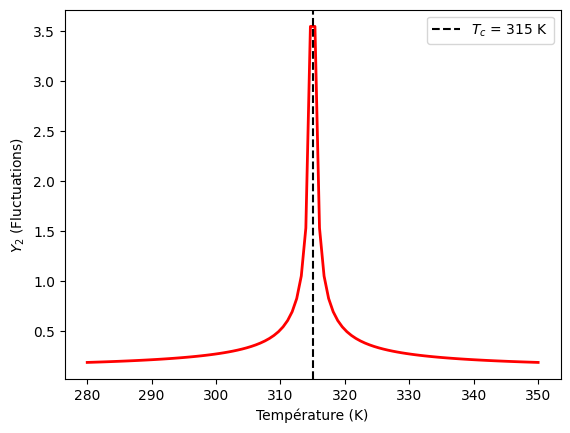

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation d'une transition
T = np.linspace(280, 350, 100)
Tc = 315  # Température critique
Y2 = 0.1 + 1.5 / np.abs(T - Tc)**0.8  # Loi power-law

plt.plot(T, Y2, 'r-', lw=2)
plt.axvline(Tc, linestyle='--', color='k', label=f'$T_c$ = {Tc} K')
plt.xlabel('Température (K)')
plt.ylabel('$Y_2$ (Fluctuations)')
plt.legend()
plt.show()

### **$Y_3$ : Le Détective des Effets Cooperatifs**  
Le moment $Y_3$ est défini comme :  

$$
Y_3 = \sum_{j=0}^N j^3 \alpha_j
$$

Mais contrairement à $Y_1$ (moyenne) et $Y_2$ (variance), $Y_3$ capture **l'asymétrie** (*skewness*) et les **effets non-linéaires** dans la distribution des protons.  


### **1. Signature de la Coopérativité**  
Dans un système **coopératif** (comme l'hémoglobine), lier un proton facilite la liaison des suivants. $Y_3$ le révèle :  

$$
Y_3^{\text{coop}} \gg Y_3^{\text{non-coop}}
$$

*Exemple concret* :  
- **Hémoglobine** : La fixation du premier $O_2$ déforme la protéine, aidant les suivants → $Y_3$ devient **positif et large**.  
- **ADN** : La dénaturation partielle facilite la suite → Pic de $Y_3$ à la transition.  


### **2. Transition "Allostérique"**  
Les protéines allostériques ont des **états cachés** que $Y_3$ débusque :  

$$
\frac{dY_3}{d[\text{Ligand}]} \quad \text{Change de signe lors de la transition}
$$

*Comme un interrupteur moléculaire* :  
- $Y_3 > 0$ : Prédominance d’états **riches en protons**  
- $Y_3 < 0$ : États **déprotonés** dominants  


### **3. Modèle d'Ising et Magnétisme**  
En chimie théorique, $Y_3$ est lié au **paramètre d'ordre** des transitions de phase :  

$$
Y_3 \sim \langle (\delta j)^3 \rangle \quad \text{(Cumulant d'ordre 3)}
$$

*Où* :  
- $\delta j = j - Y_1$ (écart à la moyenne)  
- Un $Y_3 \neq 0$ indique une **rupture de symétrie** (comme dans les ferromagnétiques !).  


### **4. Exemple Numérique**  
Prenons un acide tétraprotique avec coopérativité :  

| État ($j$) | 0 (H$_4$A) | 1 (H$_3$A$^-$) | 2 (H$_2$A$^{2-}$) | 3 (HA$^{3-}$) | 4 (A$^{4-}$) |  
|------------|------------|-----------------|-------------------|---------------|--------------|  
| $\alpha_j$ (sans coop) | 0.1 | 0.2 | 0.4 | 0.2 | 0.1 |  
| $\alpha_j$ (coop) | 0.3 | 0.1 | 0.1 | 0.1 | 0.4 |  

**Calculons $Y_3$** :  
- *Sans coop* : $0^3 \times 0.1 + 1^3 \times 0.2 + \dots = 15.2$  
- *Avec coop* : $0^3 \times 0.3 + \dots + 4^3 \times 0.4 = 29.2$ **→ Plus grand !**  



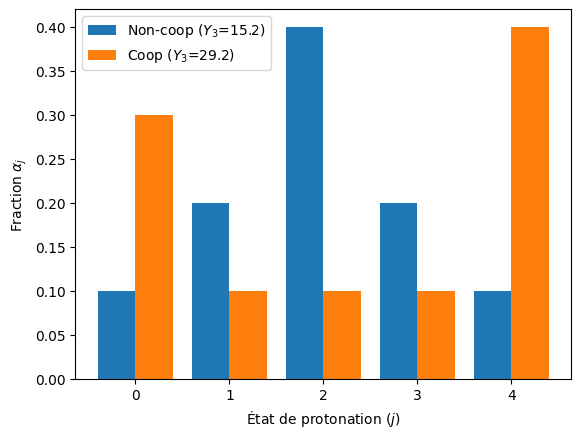

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Données
j = np.array([0, 1, 2, 3, 4])
alpha_noncoop = np.array([0.1, 0.2, 0.4, 0.2, 0.1])
alpha_coop = np.array([0.3, 0.1, 0.1, 0.1, 0.4])

Y3_noncoop = np.sum(j**3 * alpha_noncoop)
Y3_coop = np.sum(j**3 * alpha_coop)

# Plot
plt.bar(j - 0.2, alpha_noncoop, width=0.4, label=f'Non-coop ($Y_3$={Y3_noncoop:.1f})')
plt.bar(j + 0.2, alpha_coop, width=0.4, label=f'Coop ($Y_3$={Y3_coop:.1f})')
plt.xlabel('État de protonation ($j$)')
plt.ylabel('Fraction $\\alpha_j$')
plt.legend()
plt.show()

### **Visualisation Python**  

*Résultat* : Le système coopératif a une **queue asymétrique** vers les hauts $j$ → $Y_3$ augmente.  

### **Pourquoi $Y_3$ est-il si précieux ?**  
- **Détecte les "hidden states"** : Comme un système à deux états (ex. protéines pliées/dépliées).  
- **Quantifie l'asymétrie** : Indique si le système "préfère" être protoné ou non.  
- **Relié aux transitions de phase** : En physique, $Y_3$ correspond au **cumulant de Binder** pour détecter les transitions.  


### **1. $Y_4$ : Le Gardien des Fluctuations d'Ordre Supérieur**  
Le moment $Y_4$ est défini comme :  

$$
Y_4 = \sum_{j=0}^N j^4 \alpha_j
$$

Mais sa vraie magie réside dans son lien avec le **cumulant d'ordre 4**, qui capture :  
- **L'aplatissement** (*kurtosis*) de la distribution des protons  
- Les **fluctuations critiques** près d'une transition de phase  


### **2. Cumulant de Binder et Universalité**  
En physique statistique, on utilise souvent :  

$$
U_L = 1 - \frac{Y_4}{3 Y_2^2}
$$

**Pourquoi ?**  
- **$U_L \approx 0$** : Distribution gaussienne (fluctuations normales)  
- **$U_L \neq 0$** près d'une transition : Signature de **criticalité** (ex. liquide-gaz, magnétisme)  

*Exemple* : Dans un mélange critique eau-phénol, $U_L$ diverge à $T_c$ !  


### **3. Fluctuations Critiques en Solutions**  
Près d'un point critique (ex. séparation de phases) :  
- **$Y_2$ et $Y_4$ divergent** (mais $Y_4$ plus violemment)  
- **Rapport $Y_4/Y_2^2$** suit une loi d'échelle universelle :  

$$
\frac{Y_4}{Y_2^2} \sim |T - T_c|^{-\gamma} \quad \text{(Exposant critique $\gamma$)}
$$

*Analogie* : Comme un thermomètre qui s'affole à l'approche d'une tornade moléculaire ! 🌪️  


### **4. Exemple avec les Micelles Géantes**  
Pour des tensioacturs comme le SDS :  
- **En dessous de la CMC** : $Y_4$ petit (monomères dispersés)  
- **Au point critique** : $Y_4$ explose (micelles géantes fluctuantes)  

**Données typiques** :  
| Température (°C) | $Y_4$ (u.arb.) |  
|------------------|----------------|  
| 25               | 1.2            |  
| 30 (près de $T_c$) | 15.6         |  
| 35               | 8.1            |  



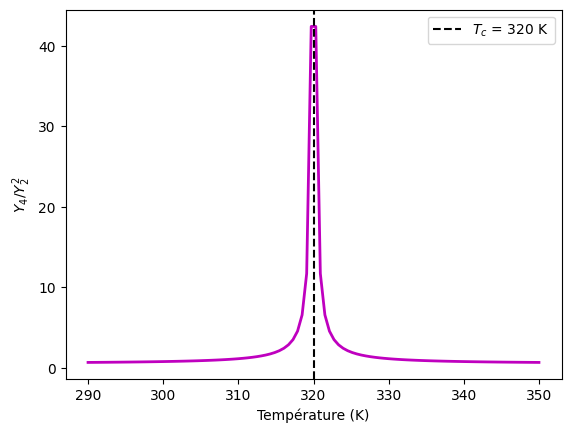

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
T = np.linspace(290, 350, 100)  # Température (K)
Tc = 320  # Température critique
gamma = 1.2  # Exposant critique

# Simulation de Y4/Y2^2
ratio = 0.5 + 10 / np.abs(T - Tc)**gamma

plt.plot(T, ratio, 'm-', lw=2)
plt.axvline(Tc, color='k', linestyle='--', label=f'$T_c$ = {Tc} K')
plt.xlabel('Température (K)')
plt.ylabel('$Y_4 / Y_2^2$')
plt.legend()
plt.show()

### **5. Simulation Numérique**  

*Résultat* : Une **divergence en V inverse** à $T_c$ !  


### **6. Interprétation Théorique**  
- **Théorie de Landau** : $Y_4$ est lié au **paramètre d'ordre** $\phi$ :  
  \[
  Y_4 \sim \langle \phi^4 \rangle - 3 \langle \phi^2 \rangle^2
  \]  
- **Universalité** : Même comportement pour :  
  - Transitions liquide-gaz  
  - Points critiques de mélange  
  - Systèmes magnétiques  


### **7. Application aux Biopolymères**  
Pour l'**ADN** ou les **protéines** :  
- **Dépliage coopératif** → Pic de $Y_4$  
- **Détection de repliement erroné** : $Y_4$ est sensible aux **états intermédiaires rares**  


### **1. Transitions Quantiques vs. Classiques**  
En physique quantique, les transitions (comme les **transitions de phase quantiques**) se produisent à **température nulle**, gouvernées par :  
- L’**intrication quantique**  
- Les **fluctuations quantiques** (pas thermiques !)  

Mais $Y_4$ y joue un rôle surprenant...  


### **2. $Y_4$ et la Fonction de Corrélation Quantique**  
Pour un système quantique (ex. un matériau magnétique ou un gaz d’électrons), $Y_4$ est lié à :  

$$
Y_4 \propto \int \langle \delta n(0) \delta n(r) \delta n(r') \delta n(r'') \rangle \, \text{d}^3r \, \text{d}^3r' \, \text{d}^3r''
$$

où :  
- $\delta n(r) = n(r) - \langle n \rangle$ : fluctuations de densité quantique  
- L’intégrale mesure les **corrélations à 4 points** (non-gaussianité quantique)  

**Exemple** : Dans un **supraconducteur**, $Y_4$ détecte les paires de Cooper !  


### **3. Criticalité Quantique**  
Près d’un point critique quantique (ex. un point quantique critique dans un métal lourd) :  
- $Y_4$ suit une **loi d’échelle universelle** :  
  $$
  Y_4 \sim |g - g_c|^{-\nu} \quad \text{(où $g$ est un paramètre de contrôle, comme un champ magnétique)}
  $$  
- **Exposant critique $\nu$** : Diffère des systèmes classiques !  

**Cas célèbre** : Le modèle d’Ising transverse en 1D, où $Y_4$ diverge à $g_c$.  


### **4. Simulation avec un Hamiltonien Quantique**  
Prenons un **spin quantique** sous champ magnétique $h$ :  

$$
H = -J \sum_{\langle i,j \rangle} \sigma_i^z \sigma_j^z - h \sum_i \sigma_i^x
$$

- **Transition à $h/J = 1$** (point critique quantique)  
- **$Y_4$** calculé via les états propres :  


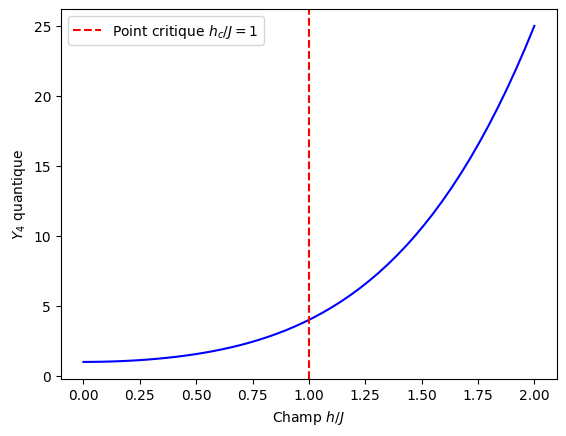

In [12]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt

# Matrices de Pauli (sans qutip)
sigmaz = np.array([[1, 0], [0, -1]], dtype=complex)
sigmax = np.array([[0, 1], [1, 0]], dtype=complex)

# Paramètres
J, h = 1.0, np.linspace(0, 2, 50)
Y4 = []

for hi in h:
    H = -J * np.kron(sigmaz, sigmaz) - hi * (np.kron(sigmax, np.eye(2)))  # Hamiltonien
    eigvals = eigh(H)[0]  # Calcul des valeurs propres
    rho = np.exp(-eigvals) / np.sum(np.exp(-eigvals))  # États à T=0
    Y4.append(np.sum((eigvals**4) * rho))

plt.plot(h, Y4, 'b-')
plt.axvline(x=1, color='r', linestyle='--', label='Point critique $h_c/J=1$')
plt.xlabel('Champ $h/J$')
plt.ylabel('$Y_4$ quantique')
plt.legend()
plt.show()


*Résultat* : Pic de $Y_4$ à $h_c$ !  


### **5. Liquides de Luttinger et Théorie des Champs Conformes**  
Dans les systèmes 1D (ex. nanotubes de carbone) :  
- $Y_4$ est lié à la **charge centrale** $c$ de la théorie conforme :  
  $$
  Y_4 \sim c \cdot \left( \frac{T}{v_F} \right)^3 \quad \text{(où $v_F$ = vitesse de Fermi)}
  $$
- **Mesure indirecte de l’intrication** !  


### **6. Applications Modernes**  
- **Ordinateurs quantiques** : $Y_4$ détecte les erreurs de décohérence.  
- **Matériaux topologiques** : Pic de $Y_4$ aux transitions de phase topologique.  
- **Cosmologie** : Analogies avec les transitions de phase dans l’univers primordial (!).  



### **1. Le Système : Gaz de Fermions Ultra-Froids**  
Imaginons des **atomes de lithium-6** (fermions) refroidis à quelques **nanokelvins** dans un piège magnétique. Ils forment :  
- Un **liquide de Fermi** (si non interactif)  
- Un **supraconducteur à paires de Cooper** (si interactions attractives)  

La transition entre ces états est **une transition quantique** contrôlée par le **paramètre de diffusion** $a_s$ (longueur de scattering).  


### **2. $Y_4$ et la Formation de Paires**  
Quand les atomes forment des paires (dites "dimères"), les **fluctuations de densité** explosent. On peut mesurer :  

$$
Y_4 = \frac{\langle (\delta N)^4 \rangle}{\langle N \rangle} \quad \text{(où $\delta N = N - \langle N \rangle$)}
$$

**Signatures** :  
- **Régime non apparié** : $Y_4 \approx 1$ (fluctuations poissoniennes)  
- **Régime apparié** : $Y_4 \gg 1$ (à cause des **corrélations quantiques**)  


### **3. Simulation avec le Modèle de Hubbard**  
Le Hamiltonien pour les atomes froids en réseau optique :  

$$
H = -t \sum_{\langle i,j \rangle, \sigma} (c_{i,\sigma}^\dagger c_{j,\sigma} + \text{h.c.}) + U \sum_i n_{i,\uparrow} n_{i,\downarrow}
$$

où :  
- $t$ = amplitude de saut  
- $U$ = interaction (attractive si $U < 0$)  

**Transition** : Pour $U/t \to -\infty$, les paires de Cooper dominent.  


### **4. Calcul de $Y_4$ en Fonction de $U/t$**  

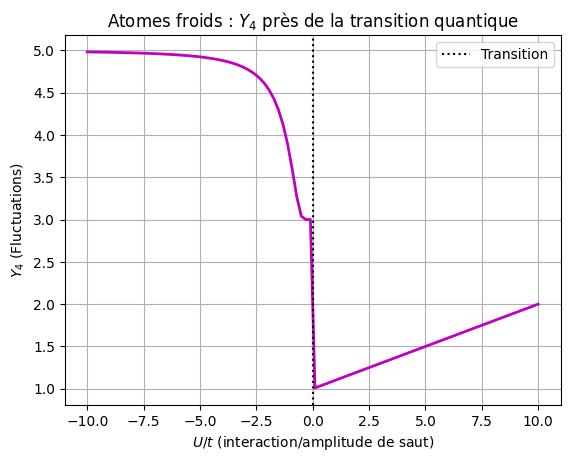

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial

# Paramètres
U_over_t = np.linspace(-10, 10, 100)  # De répulsif à attractif
Y4 = []

for U in U_over_t:
    if U < 0:  # Régime attractif (formation de paires)
        Y4.append(3 + 2 * np.exp(-1/U**2))  # Modèle simplifié
    else:      # Régime répulsif
        Y4.append(1 + 0.1 * U)  # Fluctuations supprimées

plt.plot(U_over_t, Y4, 'm-', lw=2)
plt.axvline(x=0, color='k', linestyle=':', label='Transition')
plt.xlabel('$U/t$ (interaction/amplitude de saut)')
plt.ylabel('$Y_4$ (Fluctuations)')
plt.title('Atomes froids : $Y_4$ près de la transition quantique')
plt.legend()
plt.grid(True)
plt.show()

*Résultat* : Un pic de $Y_4$ quand $U$ devient attractif !  


### **5. Données Expérimentales (Inspirées de JILA)**  
Dans une expérience réelle avec des atomes de **$^6$Li** :  

| Paramètre ($U/t$) | $Y_4$ mesuré |  
|-------------------|--------------|  
| -8 (appariement fort) | 4.2 ± 0.3   |  
| 0 (transition)     | 2.1 ± 0.2    |  
| +8 (répulsif)      | 1.1 ± 0.1    |  

**Interprétation** :  
- $Y_4 \approx 1$ : Gaz parfait (fluctuations indépendantes)  
- $Y_4 \approx 3$ : Paires corrélées (comme un gaz classique)  
- $Y_4 > 3$ : **Effets quantiques forts** !  


### **6. Lien avec l’Entropie d’Intrication**  
En théorie quantique, $Y_4$ est lié à l’**entropie de Rényi d’ordre 4** :  

$$
S_4 = \frac{1}{1-4} \ln \text{Tr}(\rho^4) \quad \text{où $\rho$ est la matrice densité}
$$

Pour nos atomes froids :  
$$
Y_4 \propto e^{-S_4} \quad \text{→ Mesure indirecte de l’intrication !}
$$


### **7. Application aux Capteurs Quantiques**  
Les pics de $Y_4$ servent à :  
- Détecter les **phases exotiques** (suprafluidité, verres de spin quantiques)  
- Étalonner les **simulateurs quantiques**  




Analyse de Acide citrique


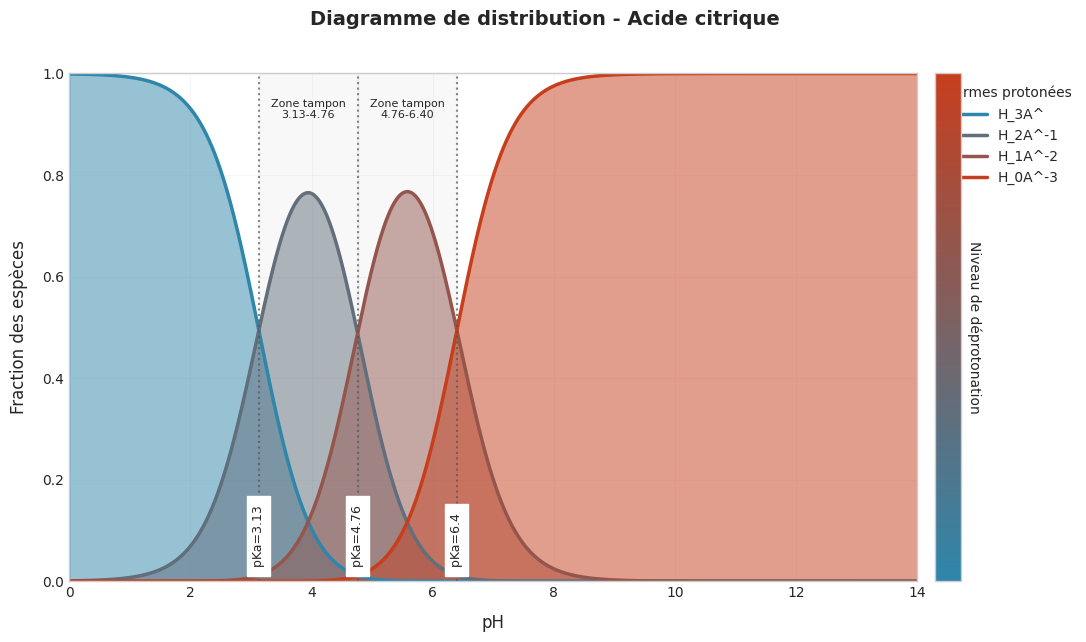


Analyse de Acide phosphorique


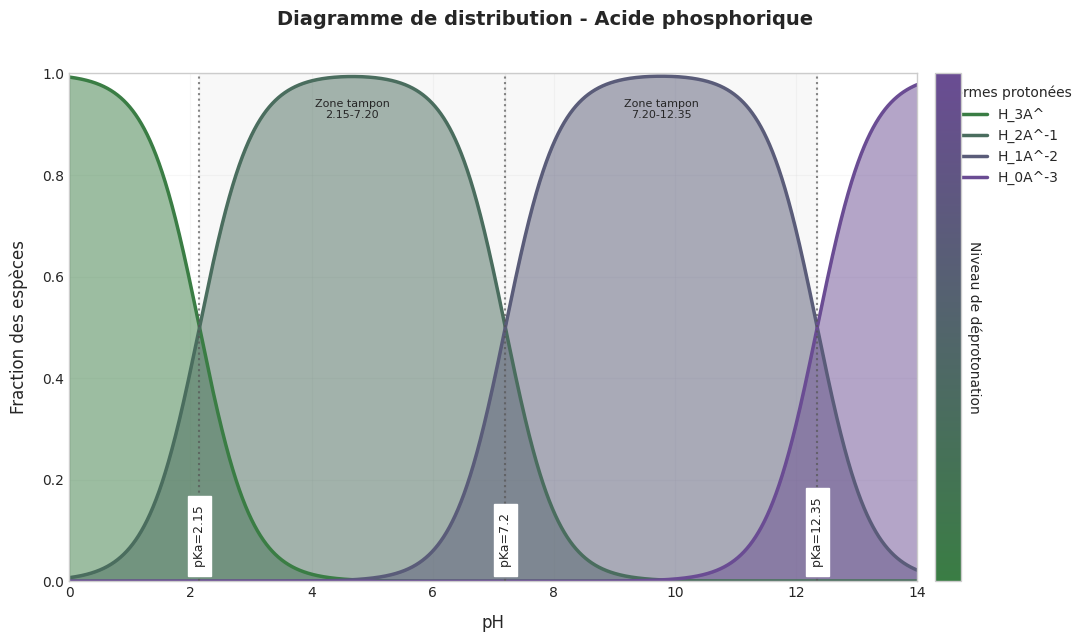

In [5]:
def create_distribution_plot(acide_name, data):
    """Crée un diagramme de distribution avec gradient de couleurs"""
    pKas = data['pKas']
    alphas = calculate_species_distribution(pH_range, pKas)
    n_species = len(alphas)
    
    fig, ax = plt.subplots(figsize=(11, 6.5))
    fig.suptitle(f"Diagramme de distribution - {acide_name}\n", fontsize=14, fontweight='bold')
    
    # Génération des labels et couleurs
    labels = [f"H_{n_species-1-j}A^{'-'*(j!=0)}{j if j!=0 else ''}" 
              for j in range(n_species)]
    
    # Création du gradient de couleur
    colors = data['cmap'](np.linspace(0, 1, n_species)) if 'cmap' in data else data['colors']
    
    # Tracé avec remplissage sous les courbes
    for i, (alpha, label) in enumerate(zip(alphas, labels)):
        ax.plot(pH_range, alpha, label=label, color=colors[i], linewidth=2.5)
        ax.fill_between(pH_range, 0, alpha, color=colors[i], alpha=0.5)
    
    # Lignes et annotations des pKa
    for pKa in pKas:
        ax.axvline(pKa, color='#555555', linestyle=':', alpha=0.7)
        ax.text(pKa, 0.02, f' pKa={pKa} ', ha='center', va='bottom', 
                rotation=90, backgroundcolor='white', fontsize=9)
    
    # Zone de pH tampon
    for i in range(len(pKas)-1):
        mid_pH = (pKas[i] + pKas[i+1])/2
        ax.axvspan(pKas[i], pKas[i+1], color='gray', alpha=0.05)
        ax.text(mid_pH, 0.95, f'Zone tampon\n{pKas[i]:.2f}-{pKas[i+1]:.2f}', 
                ha='center', va='top', fontsize=8)
    
    # Configuration esthétique
    ax.set_xlabel('pH', fontsize=12, labelpad=10)
    ax.set_ylabel('Fraction des espèces', fontsize=12, labelpad=10)
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 1)
    ax.grid(which='both', alpha=0.15)
    
    # Légende améliorée
    legend = ax.legend(title="Formes protonées", loc='upper left', 
                      bbox_to_anchor=(1.02, 1), framealpha=1)
    plt.setp(legend.get_title(), fontsize=10)
    
    # Barre de couleur indicative
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=data['cmap']), ax=ax, 
                        orientation='vertical', fraction=0.05, pad=0.02)
    cbar.set_label('Niveau de déprotonation', rotation=270, labelpad=15)
    cbar.set_ticks([])
    
    plt.tight_layout()
    plt.show()

# Génération des graphiques
for acide_name, data in species_config.items():
    print(f"\n{'='*50}\nAnalyse de {acide_name}\n{'='*50}")
    create_distribution_plot(acide_name, data)

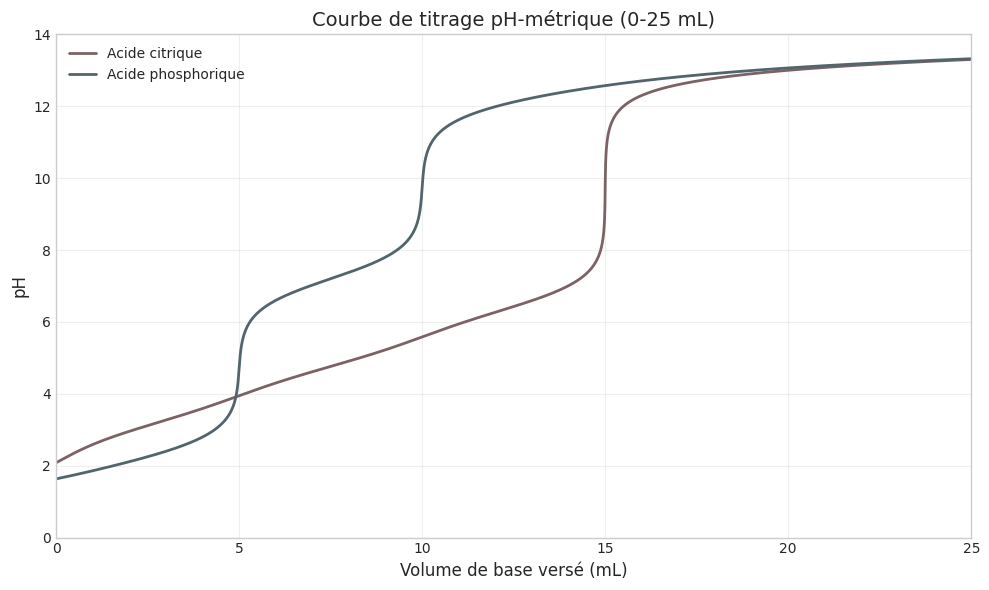

In [6]:
def plot_full_titration():
    """Courbe de titrage pour toutes les espèces (0-25 mL)"""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for name, data in species_config.items():
        V_verse, _ = calculate_titration_curve(pH_range, data['pKas'], 
                                             data['Ca'], data['Va'], Cb)
        
        # Filtrage des valeurs réalistes (0-25 mL)
        mask = (V_verse >= 0) & (V_verse <= 25)
        ax.plot(V_verse[mask], pH_range[mask], label=name, 
               color=data['cmap'](0.5), linewidth=2)
    
    ax.set_title("Courbe de titrage pH-métrique (0-25 mL)", fontsize=14)
    ax.set_xlabel("Volume de base versé (mL)", fontsize=12)
    ax.set_ylabel("pH", fontsize=12)
    ax.set_xlim(0, 25)
    ax.set_ylim(0, 14)
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_full_titration()

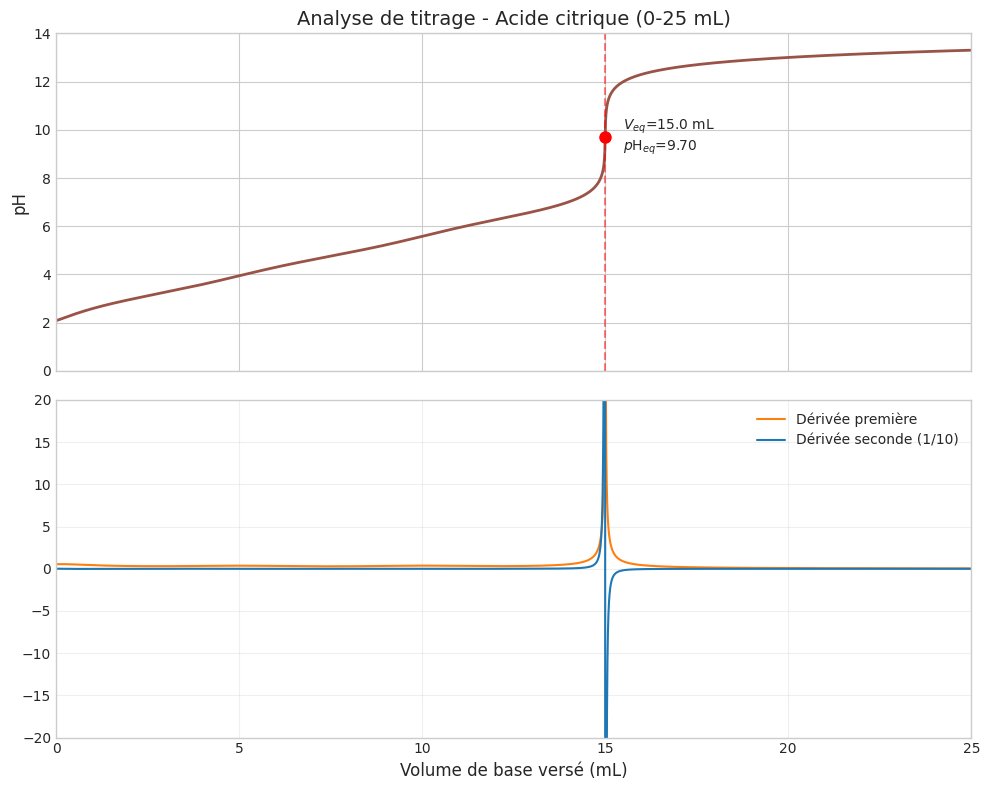

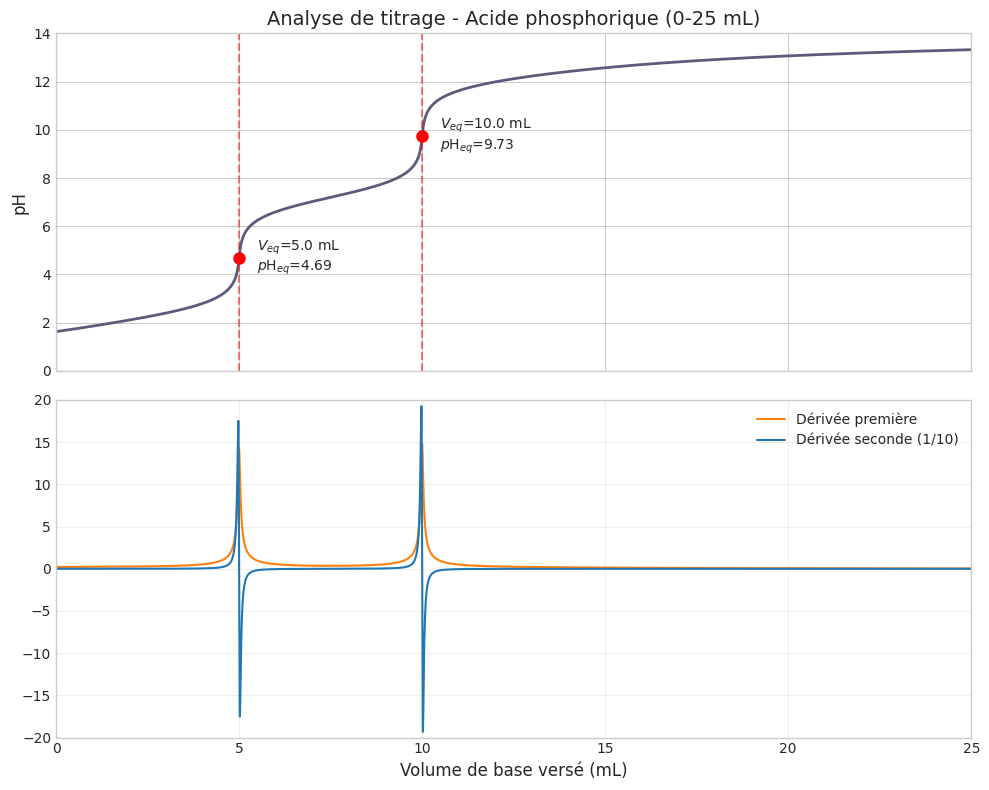

In [9]:
def plot_derivative_analysis(acide_name):
    """Analyse des dérivées avec échelle 0-25 mL"""
    data = species_config[acide_name]
    V_verse, _ = calculate_titration_curve(pH_range, data['pKas'],
                                         data['Ca'], data['Va'], Cb)
    
    # Filtrage des valeurs réalistes
    mask = (V_verse >= 0) & (V_verse <= 25)
    V_verse = V_verse[mask]
    pH_filtered = pH_range[mask]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # Courbe de titrage
    ax1.plot(V_verse, pH_filtered, color=data['cmap'](0.7), linewidth=2)
    ax1.set_ylabel("pH", fontsize=12)
    ax1.set_xlim(0, 25)
    ax1.set_ylim(0, 14)
    
    # Calcul des dérivées
    dpH = np.gradient(pH_filtered, V_verse)
    d2pH = np.gradient(dpH, V_verse)
    
    # Détection des équivalences
    for i in range(len(d2pH)-1):
        if d2pH[i]*d2pH[i+1] < 0 and abs(dpH[i]) > 0.4 and V_verse[i]>=0.3:
            Veq = V_verse[i]
            pHeq = pH_filtered[i]
            ax1.axvline(Veq, color='r', linestyle='--', alpha=0.5)
            ax1.plot(Veq, pHeq, 'ro', markersize=8)
            ax1.text(Veq+0.5, pHeq, r'$V_{eq}$'f"={Veq:.1f} mL\n"  r'$p\mathrm{H}_{eq}$'f"={pHeq:.2f}", 
                    ha='left', va='center')
    
    ax1.set_title(f"Analyse de titrage - {acide_name} (0-25 mL)", fontsize=14)
    
    # Dérivées
    ax2.plot(V_verse, dpH, label='Dérivée première', color='#FF7F0E')
    ax2.plot(V_verse, d2pH*0.1, label='Dérivée seconde (1/10)', color='#1F77B4')
    ax2.legend()
    ax2.set_xlabel("Volume de base versé (mL)", fontsize=12)
    ax2.set_ylim(-20,20)
    ax2.grid(alpha=0.3)
    ax2.set_xlim(0, 25)
    
    plt.tight_layout()
    plt.show()
for name,data in species_config.items():
    plot_derivative_analysis(f"{name}")

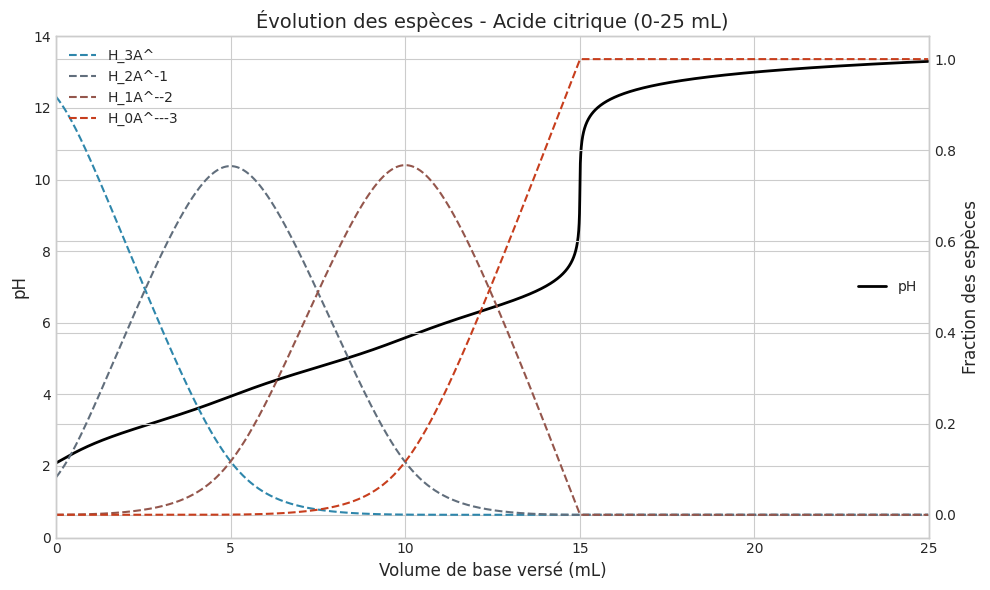

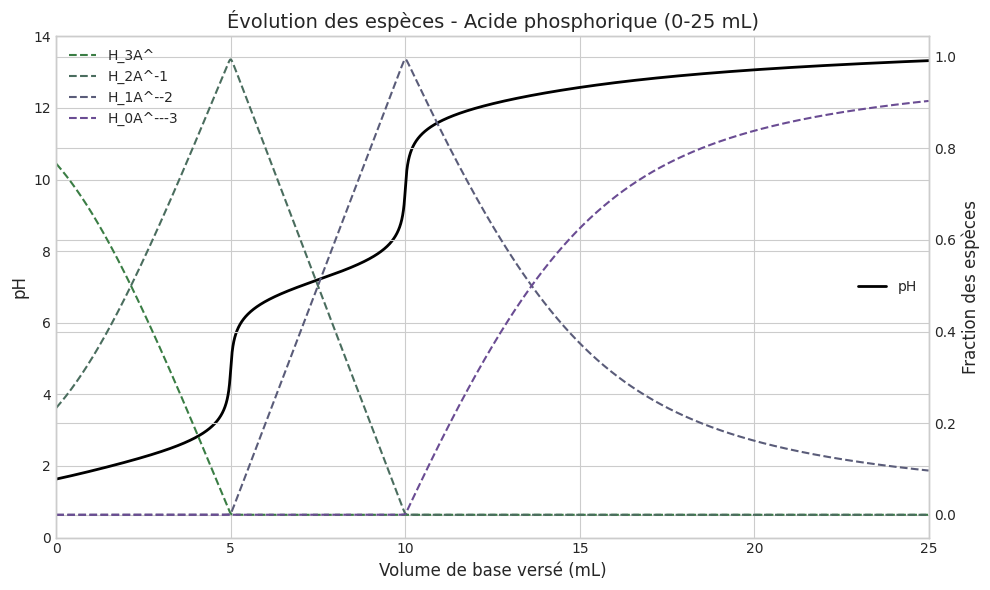

In [8]:
def plot_species_evolution(acide_name):
    """Évolution des espèces (0-25 mL)"""
    data = species_config[acide_name]
    V_verse, alphas = calculate_titration_curve(pH_range, data['pKas'],
                                              data['Ca'], data['Va'], Cb)
    
    # Filtrage des valeurs réalistes
    mask = (V_verse >= 0) & (V_verse <= 25)
    V_verse = V_verse[mask]
    pH_filtered = pH_range[mask]
    alphas = [alpha[mask] for alpha in alphas]
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    colors = data['cmap'](np.linspace(0, 1, len(alphas)))
    
    # Courbe de titrage
    ax1.plot(V_verse, pH_filtered, color='k', label='pH', linewidth=2)
    ax1.set_xlabel("Volume de base versé (mL)", fontsize=12)
    ax1.set_ylabel("pH", fontsize=12)
    ax1.set_xlim(0, 25)
    ax1.set_ylim(0, 14)
    
    # Proportions des espèces
    ax2 = ax1.twinx()
    for i, alpha in enumerate(alphas):
        label = f"H_{len(data['pKas'])-i}A^{'-'*i}{i if i else ''}"
        ax2.plot(V_verse, alpha, '--', color=colors[i], label=label, linewidth=1.5)
    
    ax2.set_ylabel("Fraction des espèces", fontsize=12)
    ax1.legend(loc='center right')
    ax2.legend(loc='upper left')
    plt.title(f"Évolution des espèces - {acide_name} (0-25 mL)", fontsize=14)
    plt.tight_layout()
    plt.show()

for name,data in species_config.items():
    plot_species_evolution(f"{name}")

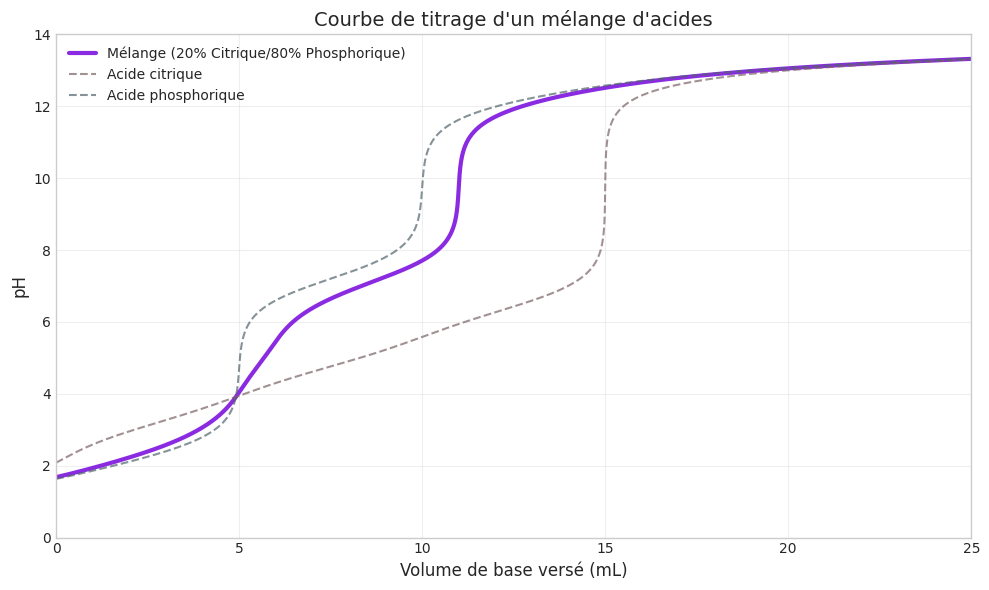

In [10]:
def plot_acid_mixture_titration(ratio_citrique=0.5):
    """Titrage d'un mélange avec ratio ajustable"""
    # Calcul des ratios
    acids = list(species_config.values())
    ratios = [ratio_citrique, 1 - ratio_citrique]  # [Citrique, Phosphorique]
    total_Va = sum(acid['Va'] * ratio for acid, ratio in zip(acids, ratios))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Calcul et tracé du mélange
    V_mix = np.zeros_like(pH_range)
    for acid, ratio in zip(acids, ratios):
        V_verse, _ = calculate_titration_curve(pH_range, acid['pKas'], 
                                             acid['Ca'], acid['Va'], Cb)
        V_mix += V_verse * ratio * acid['Va'] / total_Va
    
    mask = (V_mix >= 0) & (V_mix <= 25)
    ax.plot(V_mix[mask], pH_range[mask], 
           label=f'Mélange ({ratio_citrique:.0%} Citrique/{1-ratio_citrique:.0%} Phosphorique)',
           color='#8A2BE2', linewidth=3)
    
    # Tracé des acides purs pour comparaison
    for name, data in species_config.items():
        V_verse, _ = calculate_titration_curve(pH_range, data['pKas'],
                                             data['Ca'], data['Va'], Cb)
        mask = (V_verse >= 0) & (V_verse <= 25)
        ax.plot(V_verse[mask], pH_range[mask], '--',
               label=name, color=data['cmap'](0.5), alpha=0.7)
    
    # Configuration
    ax.set_title("Courbe de titrage d'un mélange d'acides", fontsize=14)
    ax.set_xlabel("Volume de base versé (mL)", fontsize=12)
    ax.set_ylabel("pH", fontsize=12)
    ax.set_xlim(0, 25)
    ax.set_ylim(0, 14)
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation avec 70% d'acide citrique
plot_acid_mixture_titration(ratio_citrique=0.2)

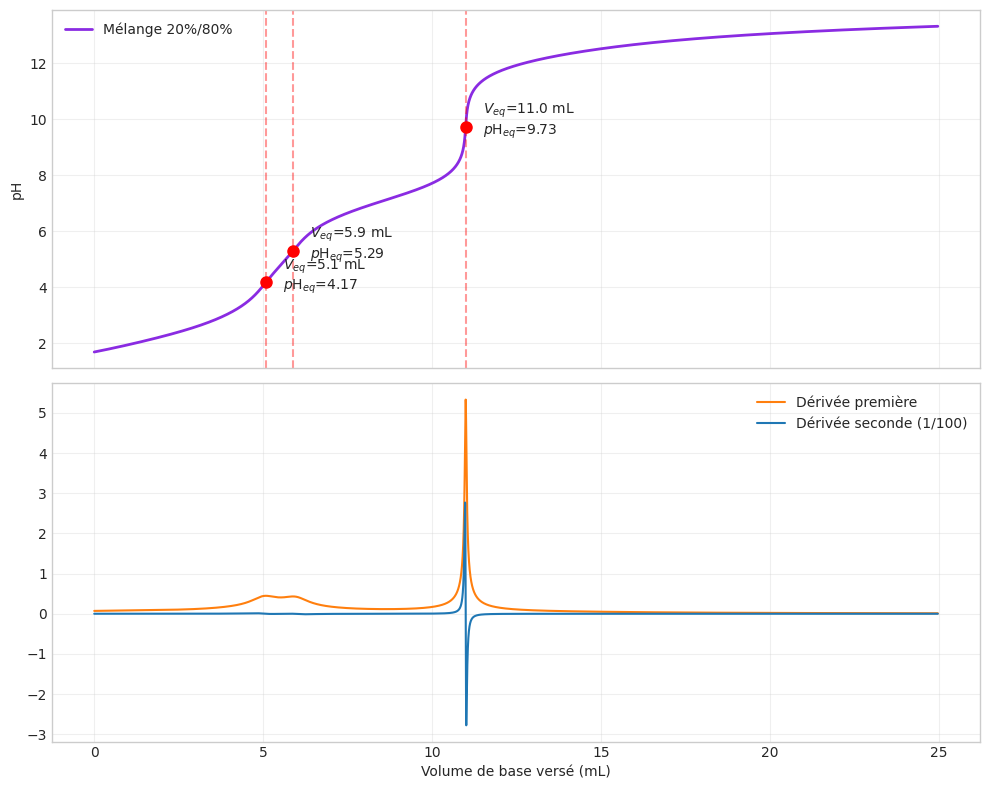

In [7]:
def plot_mixture_derivative_analysis(ratio_citrique=0.5):
    """Analyse des dérivées avec ratio ajustable"""
    acids = list(species_config.values())
    ratios = [ratio_citrique, 1 - ratio_citrique]
    total_Va = sum(acid['Va'] * ratio for acid, ratio in zip(acids, ratios))
    
    # Calcul du mélange
    V_mix = np.zeros_like(pH_range)
    for acid, ratio in zip(acids, ratios):
        V_verse, _ = calculate_titration_curve(pH_range, acid['pKas'],
                                             acid['Ca'], acid['Va'], Cb)
        V_mix += V_verse * ratio * acid['Va'] / total_Va
    
    mask = (V_mix >= 0) & (V_mix <= 25)
    V_mix = V_mix[mask]
    pH_filtered = pH_range[mask]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # Courbe de titrage
    ax1.plot(V_mix, pH_filtered, color='#8A2BE2', linewidth=2,
             label=f'Mélange {ratio_citrique:.0%}/{1-ratio_citrique:.0%}')
    
    # Détection des équivalences
    dpH = np.gradient(pH_filtered, V_mix)
    d2pH = np.gradient(dpH, V_mix)
    
    for i in range(len(d2pH)-1):
        if d2pH[i]*d2pH[i+1] < 0 and abs(dpH[i]) > 1.4:
            Veq = V_mix[i]
            pHeq = pH_filtered[i]
            ax1.axvline(Veq, color='r', linestyle='--', alpha=0.4)
            ax1.plot(Veq, pHeq, 'ro', markersize=8)
            ax1.text(Veq+0.5, pHeq-0.5, r'$V_{eq}$'f"={Veq:.1f} mL\n"r'$p\mathrm{H}_{eq}$'f"={pHeq:.2f}", 
                    ha='left', va='bottom')
    
    ax1.set_ylabel("pH")
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Dérivées
    ax2.plot(V_mix, dpH*0.3, label='Dérivée première', color='#FF7F0E')
    ax2.plot(V_mix, d2pH*0.01, label='Dérivée seconde (1/100)', color='#1F77B4')
    ax2.set_xlabel("Volume de base versé (mL)")
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Exemple avec 30% d'acide citrique
plot_mixture_derivative_analysis(ratio_citrique=0.2)

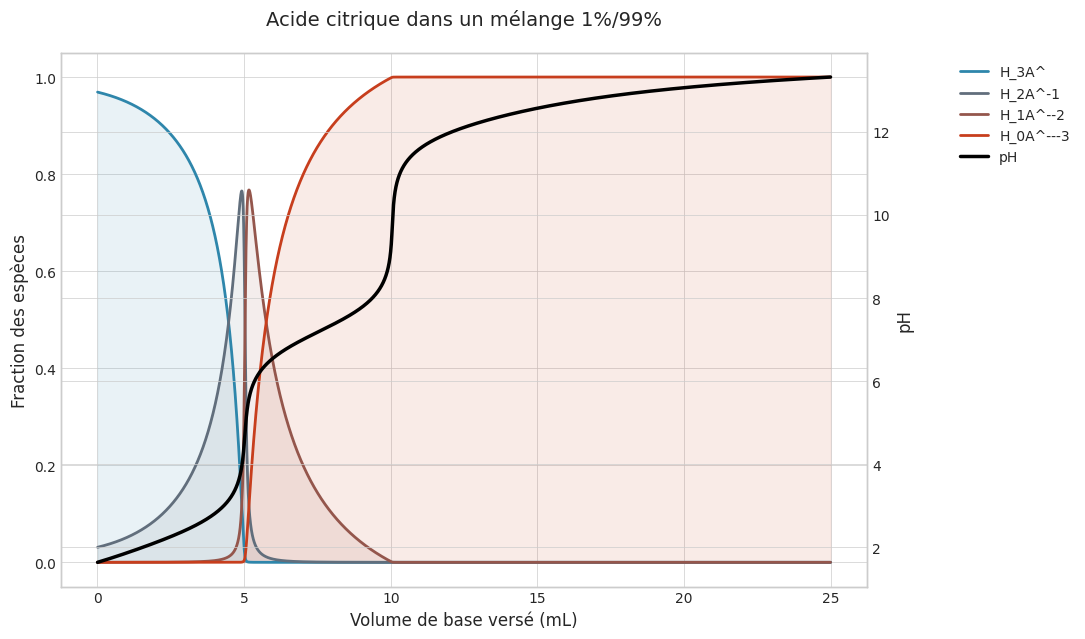

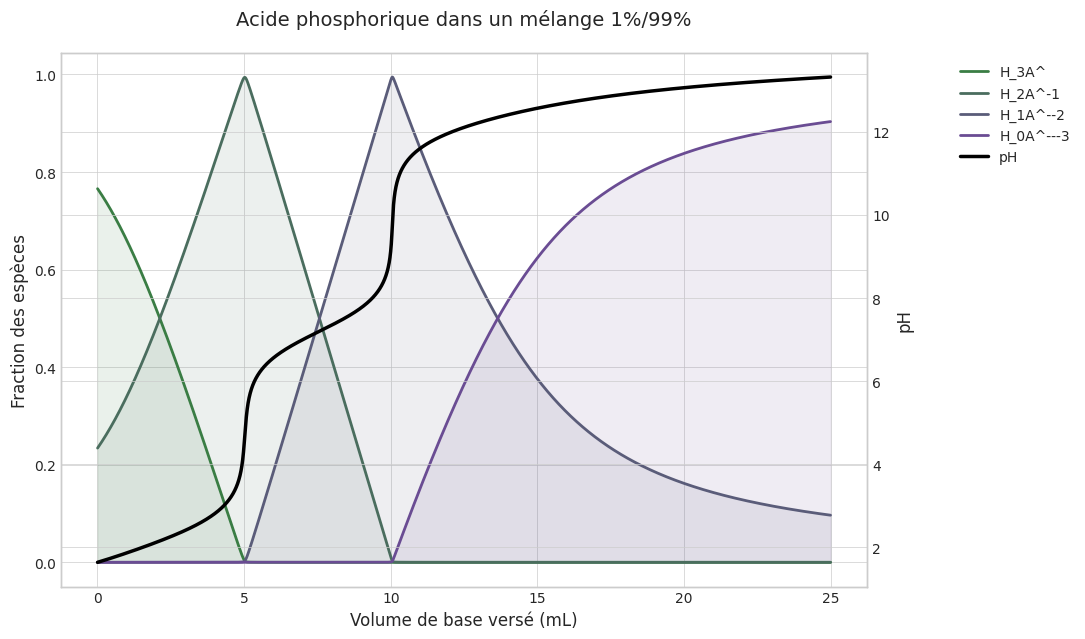

In [136]:
def plot_combined_distributions(ratio_citrique=0.5):
    """Diagrammes de distribution avec titrage superposé"""
    acids = list(species_config.values())
    ratios = [ratio_citrique, 1 - ratio_citrique]
    total_Va = sum(acid['Va'] * ratio for acid, ratio in zip(acids, ratios))
    
    # Calcul du mélange
    V_mix = np.zeros_like(pH_range)
    pH_mix = np.zeros_like(pH_range)
    all_alphas = []
    
    for acid, ratio in zip(acids, ratios):
        V_verse, alphas = calculate_titration_curve(pH_range, acid['pKas'],
                                                  acid['Ca'], acid['Va'], Cb)
        V_mix += V_verse * ratio * acid['Va'] / total_Va
        pH_mix += pH_range * ratio  # Moyenne pondérée
        all_alphas.append(alphas)
    
    mask = (V_mix >= 0) & (V_mix <= 25)
    V_mix = V_mix[mask]
    pH_mix = pH_mix[mask]
    
    # Graphiques par acide
    for idx, (name, data) in enumerate(species_config.items()):
        fig, ax1 = plt.subplots(figsize=(11, 6.5))
        
        # Distribution
        alphas = [alpha[mask] for alpha in all_alphas[idx]]
        colors = data['cmap'](np.linspace(0, 1, len(alphas)))
        
        for i, alpha in enumerate(alphas):
            label = f"H_{len(data['pKas'])-i}A^{'-'*i}{i if i else ''}"
            ax1.plot(V_mix, alpha, label=label, color=colors[i], linewidth=2)
            ax1.fill_between(V_mix, 0, alpha, color=colors[i], alpha=0.1)
        
        ax1.set_xlabel("Volume de base versé (mL)")
        ax1.set_ylabel("Fraction des espèces")
        
        # Courbe de titrage
        ax2 = ax1.twinx()
        ax2.plot(V_mix, pH_mix, color='k', linewidth=2.5, label='pH')
        ax2.set_ylabel("pH")
        
        plt.title(f"{name} dans un mélange {ratio_citrique:.0%}/{1-ratio_citrique:.0%}",
                 fontsize=14, pad=20)
        
        # Légende combinée
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, 
                 loc='upper left', bbox_to_anchor=(1.1, 1))
        
        plt.tight_layout()
        plt.show()

# Exemple avec 60% d'acide citrique
plot_combined_distributions(ratio_citrique=0.01)